In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import csv
import unidecode
import math
import utm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def calculate_weighted_mean(data):
    data['FE_VIA'] = data['FE_VIA'].apply(lambda x: 1 if math.isnan(x) else x)
    data['FE_VIA'] = data['FE_VIA'].apply(lambda x: 1 if int(x) == 0 else x)
    data['MP'] = data['FE_VIA'] * data['DURACAO']
    return data

folder_data = "../data/"
arq17 = "dados17.csv"

data17 = pd.read_csv(folder_data + arq17, dtype={'ZONA_O': str, 'ZONA_D': str}, header=0,delimiter=";", low_memory=False) 
data17 = data17.dropna(subset=['CO_O_X'])

data17 = data17.drop(['ID_DOM', 'FE_DOM', 'VIA_BICI','TP_ESTBICI','F_FAM','FE_FAM','FAMILIA','NO_MORAF',
                      'CONDMORA','QT_BANHO','QT_EMPRE','QT_AUTO','QT_MICRO','QT_LAVALOU','QT_GEL1'], axis=1)

csv_file = folder_data + "regioes17.csv"
mydict = []
with open(csv_file, mode='r') as infile:
    reader = csv.reader(infile, delimiter=";")
    mydict = {rows[0]:rows[1] for rows in reader}

csv_file = folder_data + "zonas17.csv"
zonas_nomes = []
with open(csv_file, mode='r') as infile:
    reader = csv.reader(infile, delimiter=";")
    zonas_nomes = {rows[0]:rows[1] for rows in reader}
    
data17 = data17[data17['MUNI_O'] == 36]
data17 = data17[data17['MUNI_D'] == 36]

data17['NOME_O'] = data17['ZONA_O'].apply(lambda x: '' if pd.isnull(x) else mydict[x])
data17['NOME_D'] = data17['ZONA_D'].apply(lambda x: '' if pd.isnull(x) else mydict[x])

data17['ZONA_O'] = data17['ZONA_O'].apply(lambda x: '' if pd.isnull(x) else zonas_nomes[x])
data17['ZONA_D'] = data17['ZONA_D'].apply(lambda x: '' if pd.isnull(x) else zonas_nomes[x])

data17['NUM_TRANS'] = data17[['MODO1', 'MODO2','MODO3','MODO4']].count(axis=1)

data17 = calculate_weighted_mean(data17)


data17.head()

,ZONA,MUNI_DOM,CO_DOM_X,CO_DOM_Y,F_DOM,DOM,CD_ENTRE,DATA,TIPO_DOM,AGUA,...,TIPVG,PAG_VIAG,TP_ESAUTO,VL_EST,PE_BICI,ID_ORDEM,NOME_O,NOME_D,NUM_TRANS,MP
0,1,36,333743,7394463,1,1,1,6092017,1,1,...,3.0,NaN,NaN,NaN,1.0,1,Se,Se,1,221.32647
1,1,36,333743,7394463,0,1,1,6092017,1,1,...,3.0,NaN,NaN,NaN,1.0,2,Se,Se,1,221.32647
2,1,36,333743,7394463,0,1,1,6092017,1,1,...,1.0,2.0,NaN,NaN,NaN,3,Se,Pinheiros,1,944.12435
3,1,36,333743,7394463,0,1,1,6092017,1,1,...,1.0,2.0,NaN,NaN,NaN,4,Pinheiros,Perdizes,2,1132.94922
4,1,36,333743,7394463,0,1,1,6092017,1,1,...,2.0,NaN,NaN,NaN,NaN,5,Perdizes,Se,1,755.29948


In [3]:
modos17 = {0:'outros',1:'metro',2:'trem',3:'metro 2',4:'onibus',5:'onibus',6:'onibus',7:'fretado', 8:'escolar',9:'carro-dirigindo', 10: 'carro-passageiro', 11:'taxi', 12:'taxi-nao-convencional', 13:'moto', 14:'moto-passageiro', 15:'bicicleta', 16:'pe', 17: 'outros'}
data17['MODOPRIN'] = data17['MODOPRIN'].replace(modos17)

data17['MODOPRIN'].head()

0                       pe
1                       pe
2                    metro
3                    metro
4    taxi-nao-convencional
Name: MODOPRIN, dtype: object

In [4]:
distrito = data17[['NOME_O', 'FE_VIA']].groupby(['NOME_O']).sum().sort_values(by=['FE_VIA']).reset_index()
distrito.columns = ['NOME_O', 'FE_VIA_TOTAL']
distrito = distrito.set_index('NOME_O')

distri_final = distrito

modos17 = {0:'outros',1:'metro',2:'trem',4:'onibus',7:'fretado', 8:'escolar',9:'carro-dirigindo', 
           10: 'carro-passageiro', 11:'taxi', 12:'taxi-nao-convencional', 13:'moto', 14:'moto-passageiro', 
           15:'bicicleta', 16:'pe'}


for modo in list(modos17.values()):
    modo_distri = data17[['MODOPRIN', 'NOME_O', 'FE_VIA']].groupby(['MODOPRIN','NOME_O']).sum().sort_values(by=['FE_VIA']).reset_index()
    modo_distri.columns = ['MODOPRIN', 'NOME_O', 'FE_VIA_MODO']
    modo_distri = modo_distri[modo_distri['MODOPRIN'] == modo]

    modo_distri = modo_distri.set_index('NOME_O')

    modo_distri = distrito.join(modo_distri)

    modo_distri = modo_distri.drop(['MODOPRIN'], axis=1)
    modo_distri['PORCETAGEM'] = modo_distri['FE_VIA_MODO'] / modo_distri['FE_VIA_TOTAL'] * 100
    modo_distri.columns = [modo, modo + 'Total', modo + ' (%)']
    modo_distri = modo_distri.drop([modo + 'Total'], axis=1)
    modo_distri = modo_distri.round(2)
    modo_distri[modo] = modo_distri[modo].round(0)
    modo_distri = modo_distri.drop([modo], axis=1)
    
    modo_distri = modo_distri.fillna(0)
    
    distri_final  = distri_final.join(modo_distri)
    
distri_final.tail(10)

,FE_VIA_TOTAL,outros (%),metro (%),trem (%),onibus (%),fretado (%),escolar (%),carro-dirigindo (%),carro-passageiro (%),taxi (%),taxi-nao-convencional (%),moto (%),moto-passageiro (%),bicicleta (%),pe (%)
NOME_O,,,,,,,,,,,,,,,
Cidade Ademar,410738.332398,0.21,4.77,0.48,22.65,0.00,6.58,12.75,6.77,0.00,0.54,2.40,0.33,0.02,42.50
Sacoma,439375.245757,0.10,7.37,0.00,21.99,0.04,4.61,14.95,4.90,0.29,0.47,1.96,0.00,0.43,42.90
Jardim Angela,444444.499106,0.04,3.58,1.19,32.16,0.17,9.94,7.74,3.72,0.00,0.44,3.07,0.11,0.00,37.84
Jardim Sao Luis,450745.583975,0.02,3.21,0.70,29.90,0.00,4.99,9.34,3.05,0.00,1.23,2.38,0.64,0.19,44.36
Capao Redondo,475712.383696,0.40,7.26,0.11,26.72,0.02,8.20,9.63,4.85,0.00,0.31,2.51,0.18,0.06,39.75
Vila Mariana,491211.754523,0.15,26.79,0.01,14.17,0.01,1.65,19.97,7.27,1.19,2.03,2.12,0.60,0.88,23.16
Jabaquara,504911.158280,0.00,13.69,0.00,17.58,0.00,3.74,19.91,11.77,0.16,0.78,1.44,0.22,0.06,30.66
Santo Amaro,521321.992715,0.20,7.28,4.92,32.18,0.22,2.10,22.41,7.56,0.58,0.91,2.24,0.40,0.38,18.61
Itaim Bibi,547033.880281,0.20,8.61,5.83,18.20,0.30,1.08,22.64,4.83,0.99,2.50,2.56,0.07,2.06,30.13


In [5]:

distrito_renda = data17[['NOME_O', 'RENDA_FA']].groupby(['NOME_O']).mean().sort_values(by=['RENDA_FA']).reset_index()
distrito_renda.columns = ['NOME_O', 'RENDA']
distrito_renda = distrito_renda.set_index('NOME_O')
distrito_renda


,RENDA
NOME_O,
Sao Rafael,2614.920579
Lajeado,2671.110391
Itaim Paulista,2769.636889
Cidade Tiradentes,2812.517945
Jardim Angela,2847.469419
...,...
Itaim Bibi,9526.298582
Vila Sonia,10073.413136
Perdizes,10462.756929


In [6]:
join = distri_final.join(distrito_renda)
join

,FE_VIA_TOTAL,outros (%),metro (%),trem (%),onibus (%),fretado (%),escolar (%),carro-dirigindo (%),carro-passageiro (%),taxi (%),taxi-nao-convencional (%),moto (%),moto-passageiro (%),bicicleta (%),pe (%),RENDA
NOME_O,,,,,,,,,,,,,,,,
Marsilac,8825.901706,0.00,5.37,3.70,43.98,0.00,6.37,10.56,1.30,0.00,0.00,1.18,0.00,0.00,27.54,3311.625422
Jaguara,39178.048148,0.00,5.22,3.42,34.32,0.00,1.81,17.08,7.67,0.00,0.77,3.23,0.27,0.00,26.21,3963.607442
Anhanguera,70167.615154,0.00,1.43,3.43,22.68,0.18,14.71,20.20,11.20,0.00,0.00,1.91,0.00,0.00,24.25,3525.498544
Pari,72105.020777,0.82,10.32,4.85,24.35,0.00,4.24,11.79,8.06,0.02,0.71,2.81,0.00,2.37,29.67,3813.716759
Jaguare,98783.568674,0.18,6.42,2.92,19.88,0.00,6.58,17.67,10.57,0.27,0.24,0.70,0.00,3.33,31.23,5119.364470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vila Mariana,491211.754523,0.15,26.79,0.01,14.17,0.01,1.65,19.97,7.27,1.19,2.03,2.12,0.60,0.88,23.16,8035.916086
Jabaquara,504911.158280,0.00,13.69,0.00,17.58,0.00,3.74,19.91,11.77,0.16,0.78,1.44,0.22,0.06,30.66,6002.553526
Santo Amaro,521321.992715,0.20,7.28,4.92,32.18,0.22,2.10,22.41,7.56,0.58,0.91,2.24,0.40,0.38,18.61,7614.052862


In [7]:

distrito_idade = data17[['NOME_O', 'IDADE']].groupby(['NOME_O']).mean().sort_values(by=['IDADE']).reset_index()
distrito_idade.columns = ['NOME_O', 'IDADE']
distrito_idade = distrito_idade.set_index('NOME_O')
distrito_idade


,IDADE
NOME_O,
Cidade Tiradentes,28.907773
Grajau,29.459165
Parelheiros,29.659466
Iguatemi,29.833333
Capao Redondo,30.169034
...,...
Perdizes,42.891182
Moema,42.986306
Jardim Paulista,43.863321


In [8]:
join = join.join(distrito_idade)
join

,FE_VIA_TOTAL,outros (%),metro (%),trem (%),onibus (%),fretado (%),escolar (%),carro-dirigindo (%),carro-passageiro (%),taxi (%),taxi-nao-convencional (%),moto (%),moto-passageiro (%),bicicleta (%),pe (%),RENDA,IDADE
NOME_O,,,,,,,,,,,,,,,,,
Marsilac,8825.901706,0.00,5.37,3.70,43.98,0.00,6.37,10.56,1.30,0.00,0.00,1.18,0.00,0.00,27.54,3311.625422,31.265060
Jaguara,39178.048148,0.00,5.22,3.42,34.32,0.00,1.81,17.08,7.67,0.00,0.77,3.23,0.27,0.00,26.21,3963.607442,34.758140
Anhanguera,70167.615154,0.00,1.43,3.43,22.68,0.18,14.71,20.20,11.20,0.00,0.00,1.91,0.00,0.00,24.25,3525.498544,30.597701
Pari,72105.020777,0.82,10.32,4.85,24.35,0.00,4.24,11.79,8.06,0.02,0.71,2.81,0.00,2.37,29.67,3813.716759,34.193772
Jaguare,98783.568674,0.18,6.42,2.92,19.88,0.00,6.58,17.67,10.57,0.27,0.24,0.70,0.00,3.33,31.23,5119.364470,34.601010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vila Mariana,491211.754523,0.15,26.79,0.01,14.17,0.01,1.65,19.97,7.27,1.19,2.03,2.12,0.60,0.88,23.16,8035.916086,40.712463
Jabaquara,504911.158280,0.00,13.69,0.00,17.58,0.00,3.74,19.91,11.77,0.16,0.78,1.44,0.22,0.06,30.66,6002.553526,37.184571
Santo Amaro,521321.992715,0.20,7.28,4.92,32.18,0.22,2.10,22.41,7.56,0.58,0.91,2.24,0.40,0.38,18.61,7614.052862,38.952308


In [9]:

distrito_tempo = data17[['NOME_O', 'DURACAO']].groupby(['NOME_O']).mean().sort_values(by=['DURACAO']).reset_index()
distrito_tempo.columns = ['NOME_O', 'DURACAO']
distrito_tempo = distrito_tempo.set_index('NOME_O')
distrito_tempo


,DURACAO
NOME_O,
Pari,21.730104
Perdizes,23.738587
Alto de Pinheiros,24.394388
Bras,25.721823
Limao,25.799499
...,...
Anhanguera,38.344828
Jardim Angela,38.595515
Grajau,39.551724


In [10]:
join = join.join(distrito_tempo)
join

,FE_VIA_TOTAL,outros (%),metro (%),trem (%),onibus (%),fretado (%),escolar (%),carro-dirigindo (%),carro-passageiro (%),taxi (%),taxi-nao-convencional (%),moto (%),moto-passageiro (%),bicicleta (%),pe (%),RENDA,IDADE,DURACAO
NOME_O,,,,,,,,,,,,,,,,,,
Marsilac,8825.901706,0.00,5.37,3.70,43.98,0.00,6.37,10.56,1.30,0.00,0.00,1.18,0.00,0.00,27.54,3311.625422,31.265060,65.024096
Jaguara,39178.048148,0.00,5.22,3.42,34.32,0.00,1.81,17.08,7.67,0.00,0.77,3.23,0.27,0.00,26.21,3963.607442,34.758140,33.516279
Anhanguera,70167.615154,0.00,1.43,3.43,22.68,0.18,14.71,20.20,11.20,0.00,0.00,1.91,0.00,0.00,24.25,3525.498544,30.597701,38.344828
Pari,72105.020777,0.82,10.32,4.85,24.35,0.00,4.24,11.79,8.06,0.02,0.71,2.81,0.00,2.37,29.67,3813.716759,34.193772,21.730104
Jaguare,98783.568674,0.18,6.42,2.92,19.88,0.00,6.58,17.67,10.57,0.27,0.24,0.70,0.00,3.33,31.23,5119.364470,34.601010,31.934343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vila Mariana,491211.754523,0.15,26.79,0.01,14.17,0.01,1.65,19.97,7.27,1.19,2.03,2.12,0.60,0.88,23.16,8035.916086,40.712463,29.497741
Jabaquara,504911.158280,0.00,13.69,0.00,17.58,0.00,3.74,19.91,11.77,0.16,0.78,1.44,0.22,0.06,30.66,6002.553526,37.184571,28.450613
Santo Amaro,521321.992715,0.20,7.28,4.92,32.18,0.22,2.10,22.41,7.56,0.58,0.91,2.24,0.40,0.38,18.61,7614.052862,38.952308,35.255385


In [11]:
join.corr()


,FE_VIA_TOTAL,outros (%),metro (%),trem (%),onibus (%),fretado (%),escolar (%),carro-dirigindo (%),carro-passageiro (%),taxi (%),taxi-nao-convencional (%),moto (%),moto-passageiro (%),bicicleta (%),pe (%),RENDA,IDADE,DURACAO
FE_VIA_TOTAL,1.000000,0.045746,0.187384,-0.070611,-0.027964,-0.118876,-0.124078,-0.195595,-0.285993,0.218372,0.134491,0.084406,0.245454,-0.162716,0.142265,0.112016,0.023098,0.011305
outros (%),0.045746,1.000000,-0.087550,-0.014559,0.044491,0.000329,-0.012807,0.000076,0.096989,-0.125213,-0.149731,-0.076428,-0.106384,0.083032,0.006282,-0.069390,-0.074839,-0.130832
metro (%),0.187384,-0.087550,1.000000,-0.042315,-0.437444,-0.191653,-0.610516,-0.088704,-0.221254,0.487864,0.361808,-0.116551,-0.036396,0.003455,-0.235074,0.344555,0.518425,-0.095815
trem (%),-0.070611,-0.014559,-0.042315,1.000000,0.034276,0.239291,0.084640,-0.175622,-0.197856,-0.053290,0.037086,-0.072349,0.009924,0.044470,-0.077164,0.020311,-0.125184,0.297700
onibus (%),-0.027964,0.044491,-0.437444,0.034276,1.000000,0.064328,0.256481,-0.132546,-0.220874,-0.270716,-0.218404,0.166811,0.133811,-0.220605,-0.141740,-0.229284,-0.270031,0.560746
fretado (%),-0.118876,0.000329,-0.191653,0.239291,0.064328,1.000000,0.113700,0.095702,0.032228,-0.125190,-0.098903,0.269113,0.040467,-0.092209,-0.084794,0.013638,-0.097680,0.102812
escolar (%),-0.124078,-0.012807,-0.610516,0.084640,0.256481,0.113700,1.000000,-0.292724,-0.035375,-0.526001,-0.566647,-0.170015,-0.083589,-0.297336,0.332947,-0.527482,-0.691596,0.338676
carro-dirigindo (%),-0.195595,0.000076,-0.088704,-0.175622,-0.132546,0.095702,-0.292724,1.000000,0.675525,0.405017,0.401831,0.315792,0.003146,0.125138,-0.756132,0.681613,0.639539,-0.337378
carro-passageiro (%),-0.285993,0.096989,-0.221254,-0.197856,-0.220874,0.032228,-0.035375,0.675525,1.000000,-0.045709,-0.026035,0.104451,-0.088785,0.211378,-0.479561,0.176624,0.287808,-0.354204
taxi (%),0.218372,-0.125213,0.487864,-0.053290,-0.270716,-0.125190,-0.526001,0.405017,-0.045709,1.000000,0.774498,0.147671,-0.043984,0.123222,-0.465571,0.806425,0.720450,-0.186771


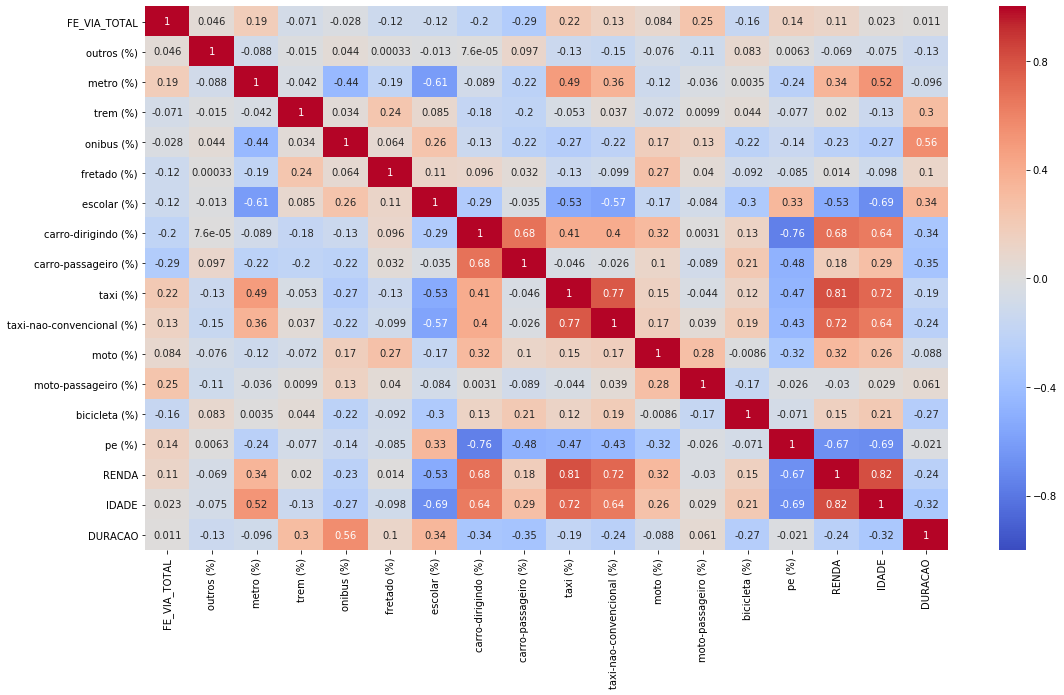

In [12]:
plt.figure(figsize=(5,5))
ax = sns.heatmap(join.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

ax.figure.set_size_inches(18,10)
ax